# Climate Time Series Forecasting Project

## Introduction to the Project:
This project aims to perform a comprehensive time series forecasting analysis on a real-world dataset. The primary goal is to compare the performance of four distinct forecasting techniques:

1. ARIMA (AutoRegressive Integrated Moving Average): A classic statistical method for forecasting time series data based on its own past values.

2. Exponential Smoothing: A widely-used technique that assigns exponentially decreasing weights to older observations.

3. Prophet: A forecasting tool from Facebook, designed to handle business-scale time series with strong seasonal patterns.

4. LSTM (Long Short-Term Memory): A type of recurrent neural network (RNN) capable of learning complex, non-linear relationships in sequential data.

By applying these diverse methodologies, we will evaluate their effectiveness in terms of predictive accuracy and identify their respective strengths and weaknesses.

## About the Dataset
The dataset selected for this analysis is the Daily Delhi Climate Data, sourced from Kaggle.

Name: Daily Climate Time Series Data

Source: [Kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download)

Key Features: This dataset contains daily climate measurements for Delhi, India, including date, meantemp, humidity, wind_speed, and meanpressure. The primary target variable for our forecasting task will be the meantemp (mean temperature). The dataset is well-suited for this project due to its clear seasonal patterns and the availability of multiple features, which will allow us to explore both univariate and multivariate forecasting approaches.

## Project Structure:
The project will follow a standard machine learning pipeline, structured into the following phases:

1. Data Loading

2. Exploratory Data Analysis (EDA) and Preprocessing.

3. Model Implementation and Training

4. Forecasting and Evaluation

5. Conclusion and Reporting

### 1. Data Loading:
 Preparing the necessary libraries and importing the dataset.

In [36]:
import pandas as pd

# Load both the training and testing datasets
train_df_raw = pd.read_csv('datasets/DailyDelhiClimateTrain.csv')
test_df_raw = pd.read_csv('datasets/DailyDelhiClimateTest.csv')

# Concatenate the two dataframes to work with a single, continuous dataset
df = pd.concat([train_df_raw, test_df_raw], ignore_index=True)

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [37]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1571,2017-04-20,34.500,27.500000,5.562500,998.625000
1572,2017-04-21,34.250,39.375000,6.962500,999.875000
1573,2017-04-22,32.900,40.900000,8.890000,1001.600000
1574,2017-04-23,32.875,27.500000,9.962500,1002.125000
1575,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [38]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1576 non-null   object 
 1   meantemp      1576 non-null   float64
 2   humidity      1576 non-null   float64
 3   wind_speed    1576 non-null   float64
 4   meanpressure  1576 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.7+ KB


### 2. Exploratory Data Analysis (EDA) and Preprocessing 
Visualizing the time series, checking for stationarity, and preparing the data for modeling.

#### 2.1 Data Cleaning and Initial Preprocessing

In [39]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

In [40]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [41]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

#### 2.2 Exploratory Data Analysis (EDA)

Now we can visualize the time series and decompose it to understand its components. We will focus on the `meantemp` column, as it is our primary target variable.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

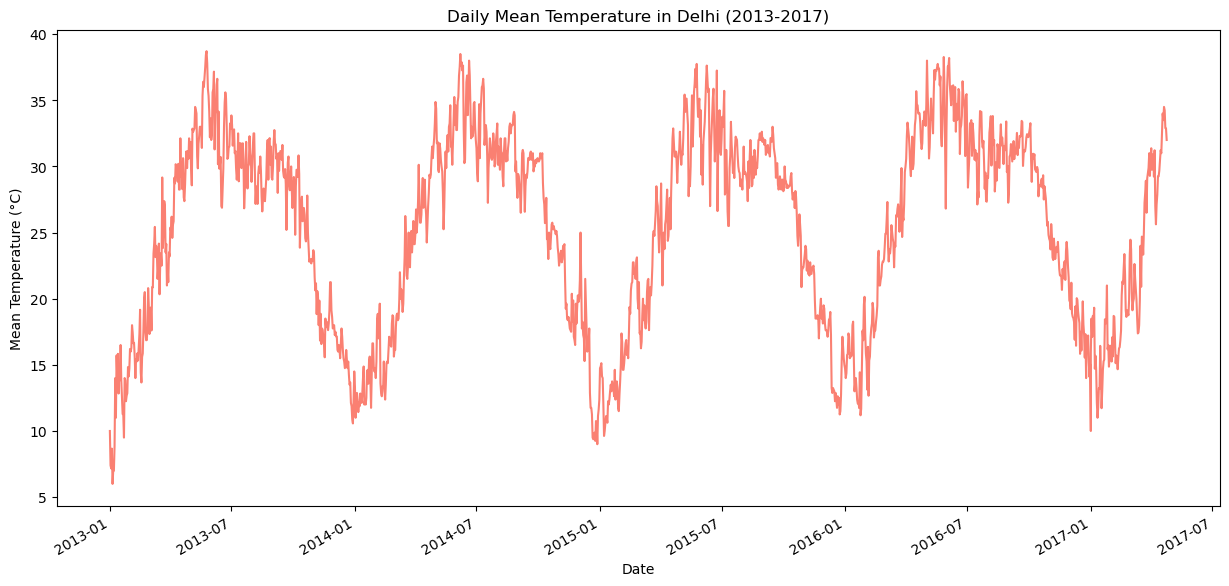

In [43]:
# Plot the mean temperature time series
plt.figure(figsize=(15, 7))
df['meantemp'].plot(title='Daily Mean Temperature in Delhi (2013-2017)', color='salmon')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.show()

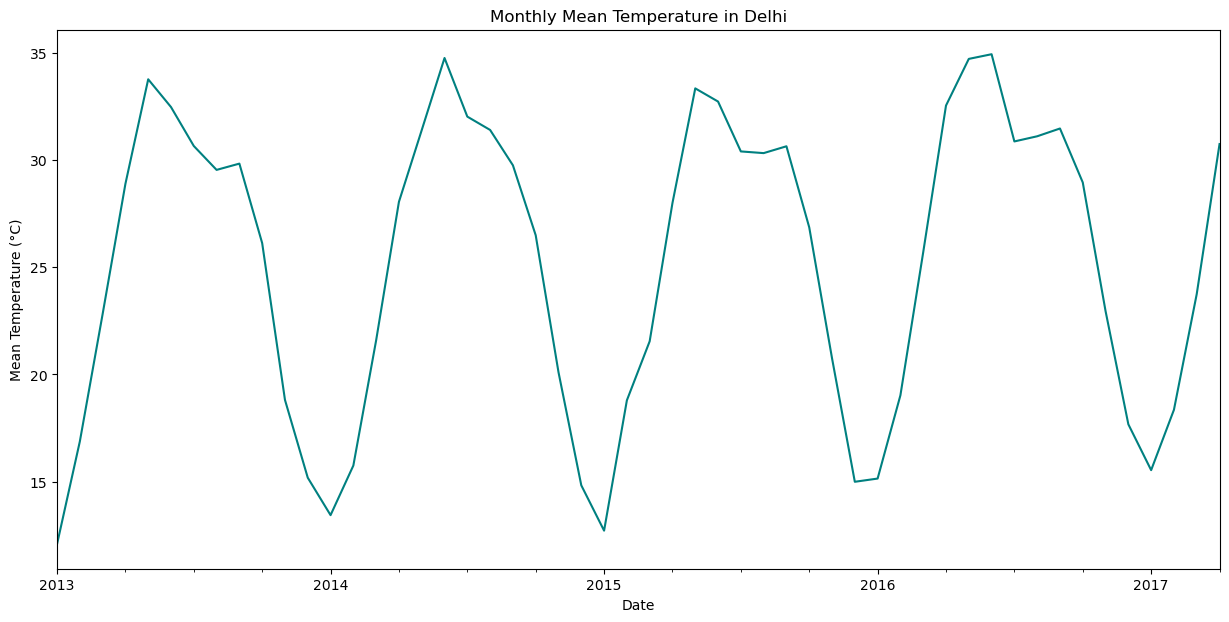

In [44]:
# Resample the data to a monthly average for a smoother trend visualization
monthly_data = df['meantemp'].resample('ME').mean()
plt.figure(figsize=(15, 7))
monthly_data.plot(title='Monthly Mean Temperature in Delhi', color='teal')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.show();

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

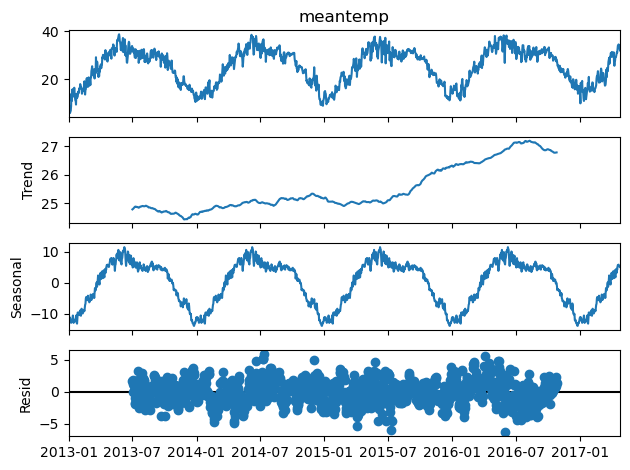

In [46]:
# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['meantemp'], model='additive', period=365) # Period is 365 for daily data
decomposition.plot()
plt.show()

The `seasonal_decompose` plot breaks down the series into its fundamental components:

* Trend: Shows the long-term direction of the series. Here, the trend appears relatively flat with a slight dip in the middle.

* Seasonal: Displays the repeating seasonal pattern, which is a strong yearly cycle.

* Residual: The remaining noise after removing the trend and seasonality.

#### 2.3 Check for Stationarity (for ARIMA)

We use the Augmented Dickey-Fuller (ADF) test to check for this.

The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value is less than or equal to 0.05, we can reject the null hypothesis and conclude the series is stationary.

In [47]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(df['meantemp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpret the result
if result[1] <= 0.05:
    print("Conclusion: The series is likely stationary.")
else:
    print("Conclusion: The series is likely non-stationary. We will need to apply differencing.")

ADF Statistic: -2.379190
p-value: 0.147696
Conclusion: The series is likely non-stationary. We will need to apply differencing.


#### 2.4 Data Splitting

In [48]:
# The original test set starts on a specific date. Let's find that date from the test_df_raw
split_date = pd.to_datetime(test_df_raw['date'].iloc[0])

In [49]:
# Split the data based on the original separation
train_df = df.loc[df.index < split_date]
test_df = df.loc[df.index >= split_date]

In [50]:
train_df.shape

(1461, 4)

In [51]:
test_df.shape

(115, 4)

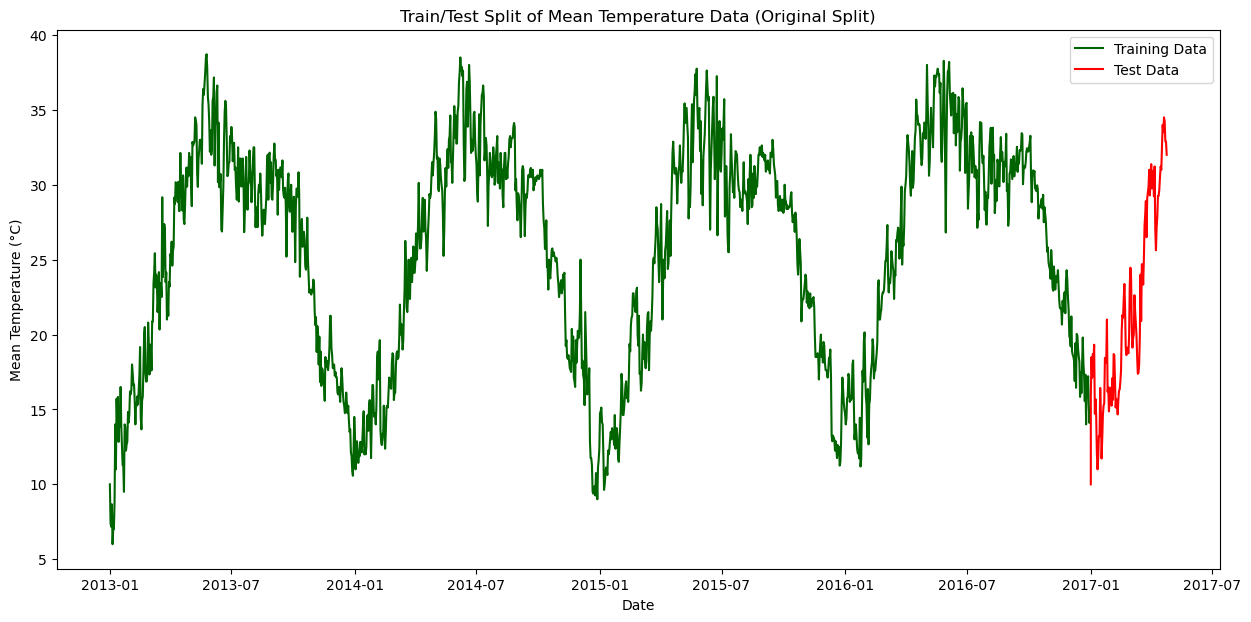

In [52]:
# Visualize the split
plt.figure(figsize=(15, 7))
plt.plot(train_df['meantemp'], label='Training Data', color='darkgreen')
plt.plot(test_df['meantemp'], label='Test Data', color='red')
plt.title('Train/Test Split of Mean Temperature Data (Original Split)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

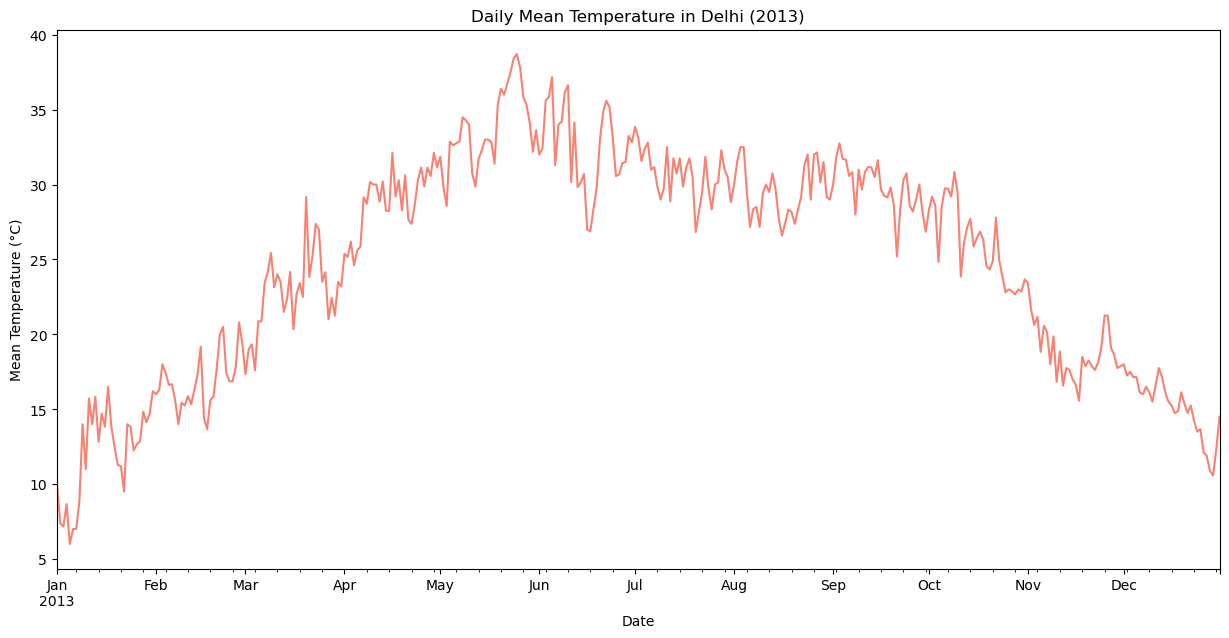

In [67]:
plt.figure(figsize=(15, 7))
df['meantemp'].loc['2013'].plot(title='Daily Mean Temperature in Delhi (2013)', color='salmon')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2013-12-31'))
plt.show()

### 3. Model Implementation and Training

This phase will focus on building and training each of the four specified models on our `train_df`. We'll also prepare a dictionary to store the evaluation metrics later for a final comparison.

In [53]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
# Initialize a dictionary to store the RMSE and MAE for each model
results = {}

# We will be forecasting the 'meantemp' column
train_series = train_df['meantemp']
test_series = test_df['meantemp']

#### 3.1 ARIMA and SARIMA

**Step 1: Check for Stationarity and Determine `d`**

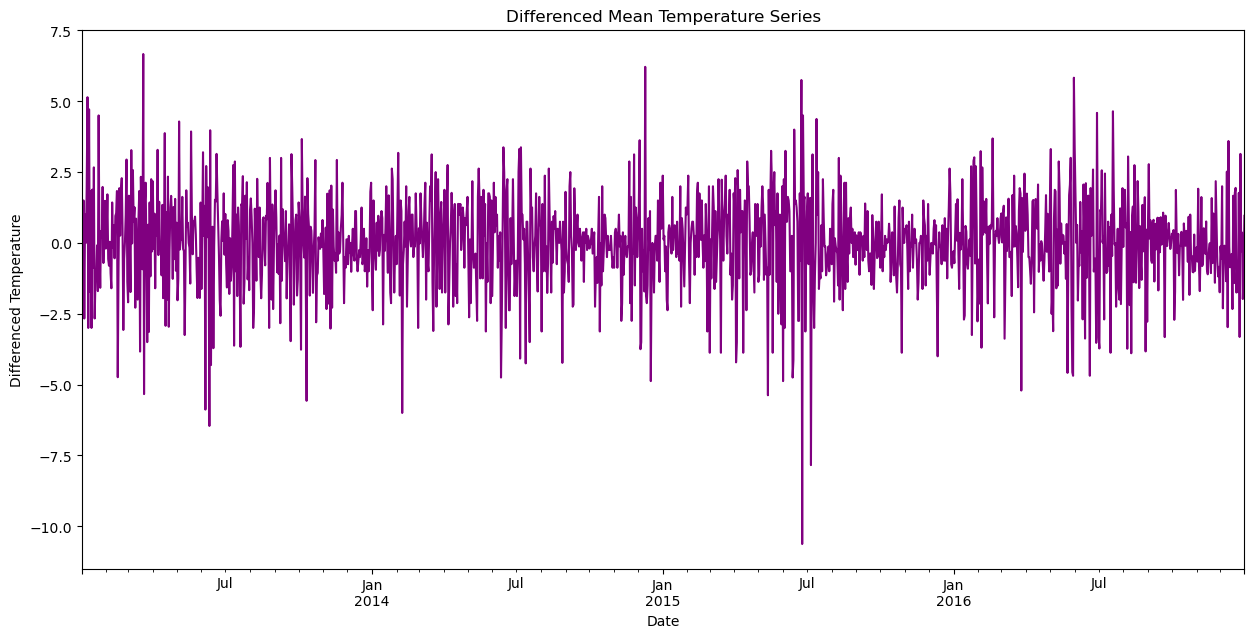

In [55]:
# Create a differenced series - Differencing
diff_series = train_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(15, 7))
diff_series.plot(title='Differenced Mean Temperature Series', color='purple')
plt.xlabel('Date')
plt.ylabel('Differenced Temperature')
plt.show()

In [56]:
# Perform ADF test on the differenced series
result_diff = adfuller(diff_series)
print('ADF Statistic (Differenced): %f' % result_diff[0])
print('p-value (Differenced): %f' % result_diff[1])
if result_diff[1] <= 0.05:
    print("Conclusion: The differenced series is likely stationary.")
else:
    print("Conclusion: The differenced series is still non-stationary.")

ADF Statistic (Differenced): -16.520441
p-value (Differenced): 0.000000
Conclusion: The differenced series is likely stationary.


The p-value should now be less than 0.05, confirming that one order of differencing (`d`=1) is sufficient to make the series stationary.

**Step 2: Plot ACF and PACF to Determine p and q**

<Figure size 800x600 with 0 Axes>

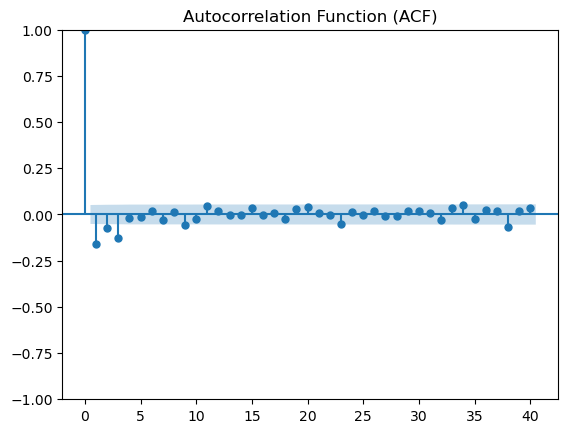

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF of the differenced series
plt.figure(figsize=(8, 6))
plot_acf(diff_series, lags=40, title='Autocorrelation Function (ACF)')
plt.show()

ACF plot (`q`): Similarly, you'll see a few significant spikes. A potential value for `q` could also be 1 or 2.

<Figure size 800x600 with 0 Axes>

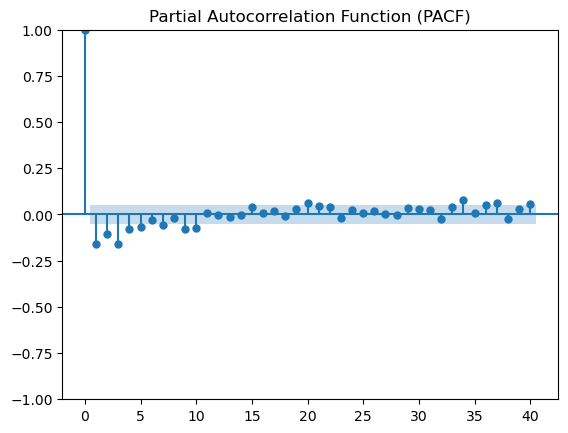

In [58]:
# Plot PACF of the differenced series
plt.figure(figsize=(8, 6))
plot_pacf(diff_series, lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

PACF plot (`p`): You'll likely see a few significant spikes at the beginning, followed by a quick drop-off. A potential value for `p` could be 1 or 2.

**Step 3: Plot Seasonal ACF and PACF to Determine `P` and `Q`**

<Figure size 800x600 with 0 Axes>

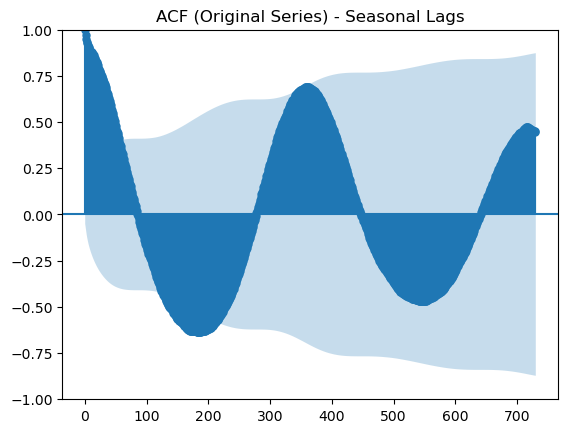

In [59]:
# Plot ACF of the original series to identify seasonal components
plt.figure(figsize=(8, 6))
plot_acf(train_series, lags=730, title='ACF (Original Series) - Seasonal Lags')
plt.show();

<Figure size 1400x600 with 0 Axes>

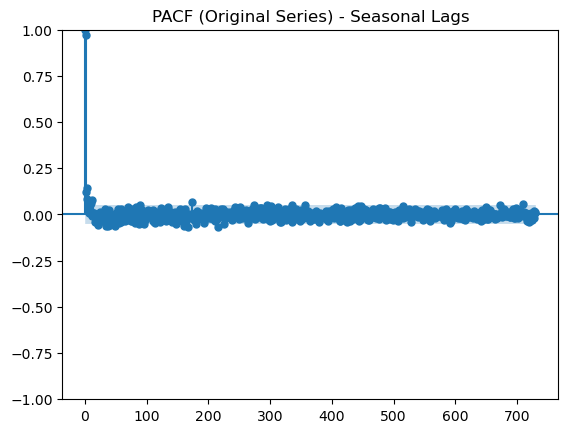

In [60]:
# Plot PACF of the original series to identify seasonal components
plt.figure(figsize=(14, 6))
plot_pacf(train_series, lags=730, title='PACF (Original Series) - Seasonal Lags')
plt.show()

Observation & Parameter Selection:

* You will likely see a very strong spike at lag 365, indicating a strong seasonal component.

* Based on the plots, a reasonable starting point might be a seasonal differencing of D=1 and P and Q of 1.

**Step 4: Train the SARIMA Model**

Based on the observations from the plots, we can now train our SARIMA model with the manually selected parameters.

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12) 

print("\nTraining SARIMA Model with manual parameters...")
sarima_model = SARIMAX(train_series,
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_model_fit = sarima_model.fit(disp=False)
print("SARIMA Model Summary (Manual):")
print(sarima_model_fit.summary())


Training SARIMA Model with manual parameters...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA Model Summary (Manual):
                                     SARIMAX Results                                      
Dep. Variable:                           meantemp   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2729.577
Date:                            Fri, 08 Aug 2025   AIC                           5469.155
Time:                                    11:35:14   BIC                           5495.496
Sample:                                01-01-2013   HQIC                          5478.990
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5735      0.046     12.522      0.000       0.484       0.663
ma.L

**Trying with auto_arima model**

`auto_arima` automatically selects the optimal parameters for ARIMA and Seasonal-ARIMA.

In [66]:
import pmdarima as pm

sarima_model = pm.auto_arima(train_series,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             m=7, 
                             start_P=0, seasonal=True,
                             d=None, D=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print("\nSARIMA Model Summary:")
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=7310.729, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6021.564, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6498.926, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=7308.975, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=6410.081, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5888.354, Time=1.34 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=7158.478, Time=1.16 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=5880.080, Time=2.38 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=6019.689, Time=0.75 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=8.92 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=5880.938, Time=2

#### 3.2 Exponential Smoothing

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


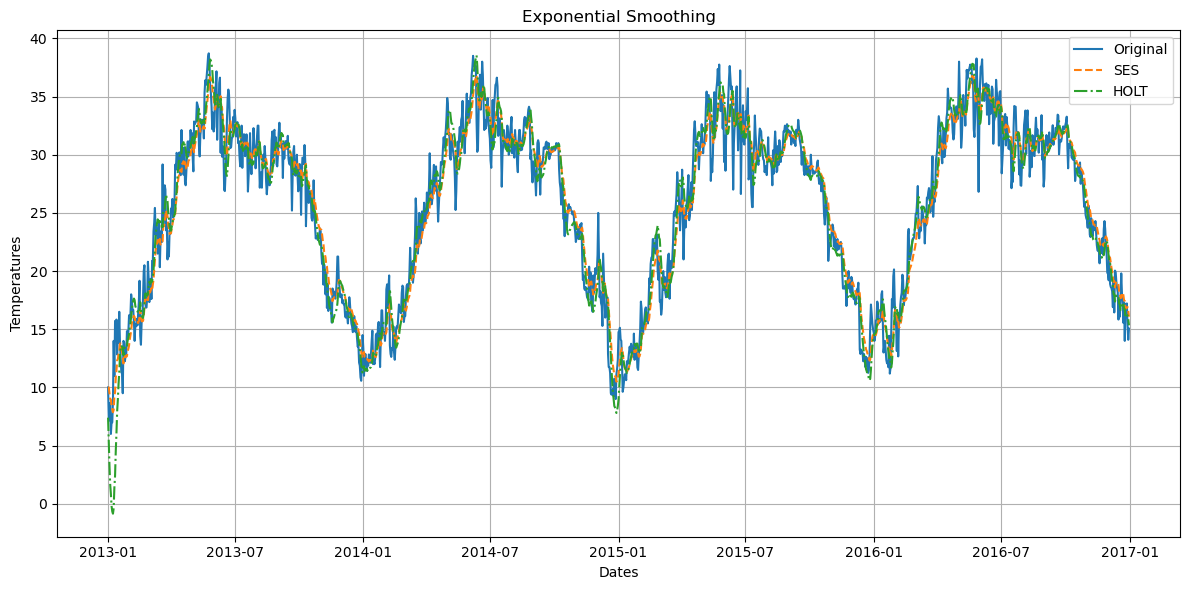

In [75]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

# 1. Simple Exponential Smoothening
ses_model= SimpleExpSmoothing(train_series).fit(smoothing_level=0.2, optimized=False)
ses_forcast = ses_model.fittedvalues

# 2. Holt Linear Trend Method
holt_model = Holt(train_series).fit(smoothing_level=0.2, optimized=True)
holt_forecast = holt_model.fittedvalues 

plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Original')
plt.plot(ses_forcast, label='SES', linestyle='--')
plt.plot(holt_forecast, label='HOLT', linestyle='-.')
plt.title('Exponential Smoothing')
plt.xlabel('Dates')
plt.ylabel('Temperatures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

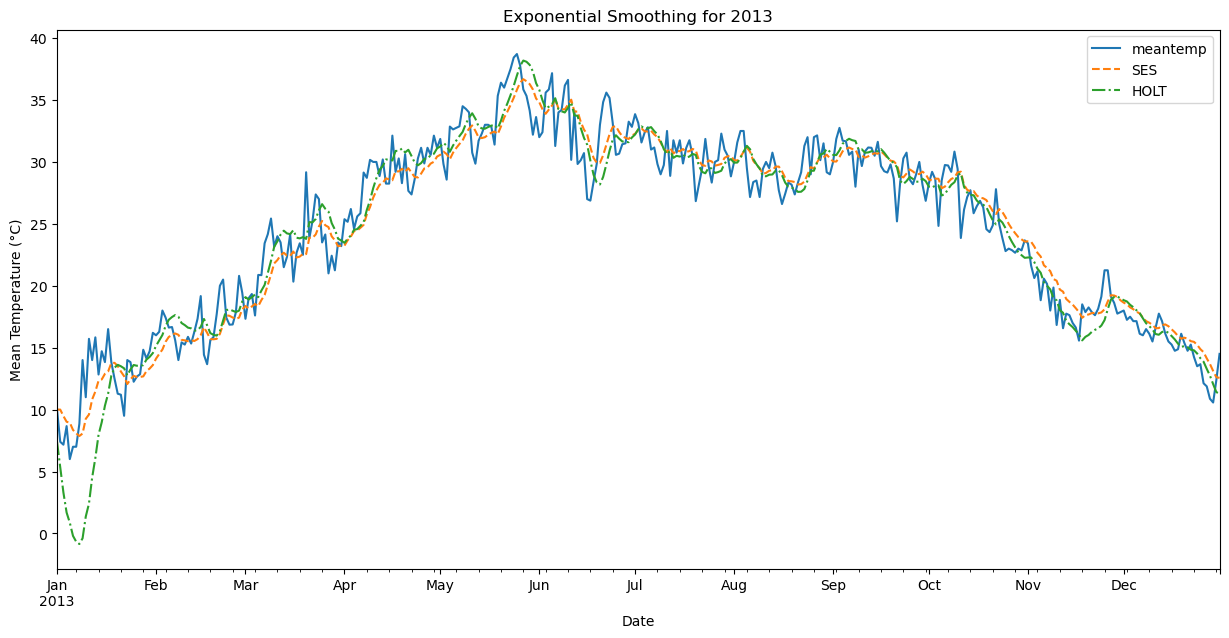

In [77]:
plt.figure(figsize=(15, 7))
train_series.loc['2013'].plot()
plt.plot(ses_forcast.loc['2013'], label='SES', linestyle='--')
plt.plot(holt_forecast.loc['2013'], label='HOLT', linestyle='-.')
plt.title('Exponential Smoothing for 2013')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2013-12-31'))
plt.legend()
plt.show()

We can see Simple Exponential Smoothing fitting the training data better than Holt Method

### 3.3 FB-Prophet Model

In [78]:
# Create a dataframe in the format required by Prophet
prophet_df = train_df.reset_index()[['date', 'meantemp']].rename(columns={'date': 'ds', 'meantemp': 'y'})

In [ ]:
from prophet import Prophet

# Initialize the Prophet model. We can specify seasonality.
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Fit the model to the training data
prophet_model.fit(prophet_df)
print("Prophet Model Trained.")

12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Trained.


### 3.4 LSTM (Long Short-Term Memory Model)

In [ ]:
import numpy as np

# TensorFlow & Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_series = scaler.fit_transform(train_series.values.reshape(-1, 1))

# 2. Sequence Creation Function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 30 # Use the last 30 days to predict the next day
X_train, y_train = create_sequences(scaled_train_series, seq_length)

# 3. Reshape input for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 4. Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

# 5. Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
print("LSTM Model Trained.")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

### 4. Forecasting and Evaluation

#### 4.1 Forecasting with Each Model

In [82]:
# SARIMA Forecaset

print("Generating SARIMA forecasts...")
sarima_forecast = sarima_model.predict(n_periods=len(test_df))
sarima_forecast_series = pd.Series(sarima_forecast, index=test_df.index)
print("SARIMA forecasts generated.")

Generating SARIMA forecasts...
SARIMA forecasts generated.


In [83]:
# Exponential Smoothing

print("Generating Exponential Smoothing forecasts...")
ets_forecast = ses_model.forecast(steps=len(test_df))
ets_forecast_series = pd.Series(ets_forecast, index=test_df.index)
print("Exponential Smoothing forecasts generated.")

Generating Exponential Smoothing forecasts...
Exponential Smoothing forecasts generated.


In [ ]:
# Prophet Forecast

print("Generating Prophet forecasts...")
future = prophet_model.make_future_dataframe(periods=len(test_df), include_history=False)
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = pd.Series(prophet_forecast['yhat'].values, index=test_df.index)
print("Prophet forecasts generated.")

Generating Prophet forecasts...
Prophet forecasts generated.


In [ ]:
# LSTM Forecast

print("Generating LSTM forecasts...")
# Prepare the initial input sequence for forecasting
last_train_data = scaled_train_series[-seq_length:]
lstm_forecasts = []

# Iteratively predict each step
for _ in range(len(test_df)):
    # Reshape input to (1, seq_length, 1) for the model
    input_seq = last_train_data.reshape(1, seq_length, 1)
    
    # Predict the next value
    predicted_scaled_value = lstm_model.predict(input_seq, verbose=0)[0][0]
    
    # Append the prediction to our list
    lstm_forecasts.append(predicted_scaled_value)
    
    # Update the input sequence for the next step by dropping the first value
    # and adding the new prediction
    new_input_seq = np.append(last_train_data[1:], [[predicted_scaled_value]], axis=0)
    last_train_data = new_input_seq

# Inverse transform the scaled predictions to the original temperature scale
lstm_forecast_series = pd.Series(scaler.inverse_transform(np.array(lstm_forecasts).reshape(-1, 1)).flatten(), index=test_df.index)
print("LSTM forecasts generated.")

Generating LSTM forecasts...
LSTM forecasts generated.


Forecasting with an LSTM is more complex. We need to iteratively predict one step at a time, using the prediction as an input for the next time step. This process is called multistep forecasting.

#### 4.2 Model Evaluation

In [87]:
# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Create a dictionary to hold the forecast series
forecasts = {
    'SARIMA': sarima_forecast_series,
    'Exponential Smoothing': ets_forecast_series,
    'Prophet': prophet_forecast_series,
    'LSTM': lstm_forecast_series
}

# Evaluate and store metrics
evaluation_metrics = {}
for model_name, forecast_series in forecasts.items():
    rmse = np.sqrt(mean_squared_error(test_series, forecast_series))
    mae = mean_absolute_error(test_series, forecast_series)
    evaluation_metrics[model_name] = {'RMSE': rmse, 'MAE': mae}

# Display the evaluation results in a DataFrame
metrics_df = pd.DataFrame(evaluation_metrics).T.round(2)
print("\nEvaluation Metrics (RMSE and MAE):")
print(metrics_df)


Evaluation Metrics (RMSE and MAE):
                        RMSE    MAE
SARIMA                 12.32   9.94
Exponential Smoothing   8.59   6.47
Prophet                 2.86   2.32
LSTM                   12.12  10.03


#### 4.3 Visualization of Forecasts

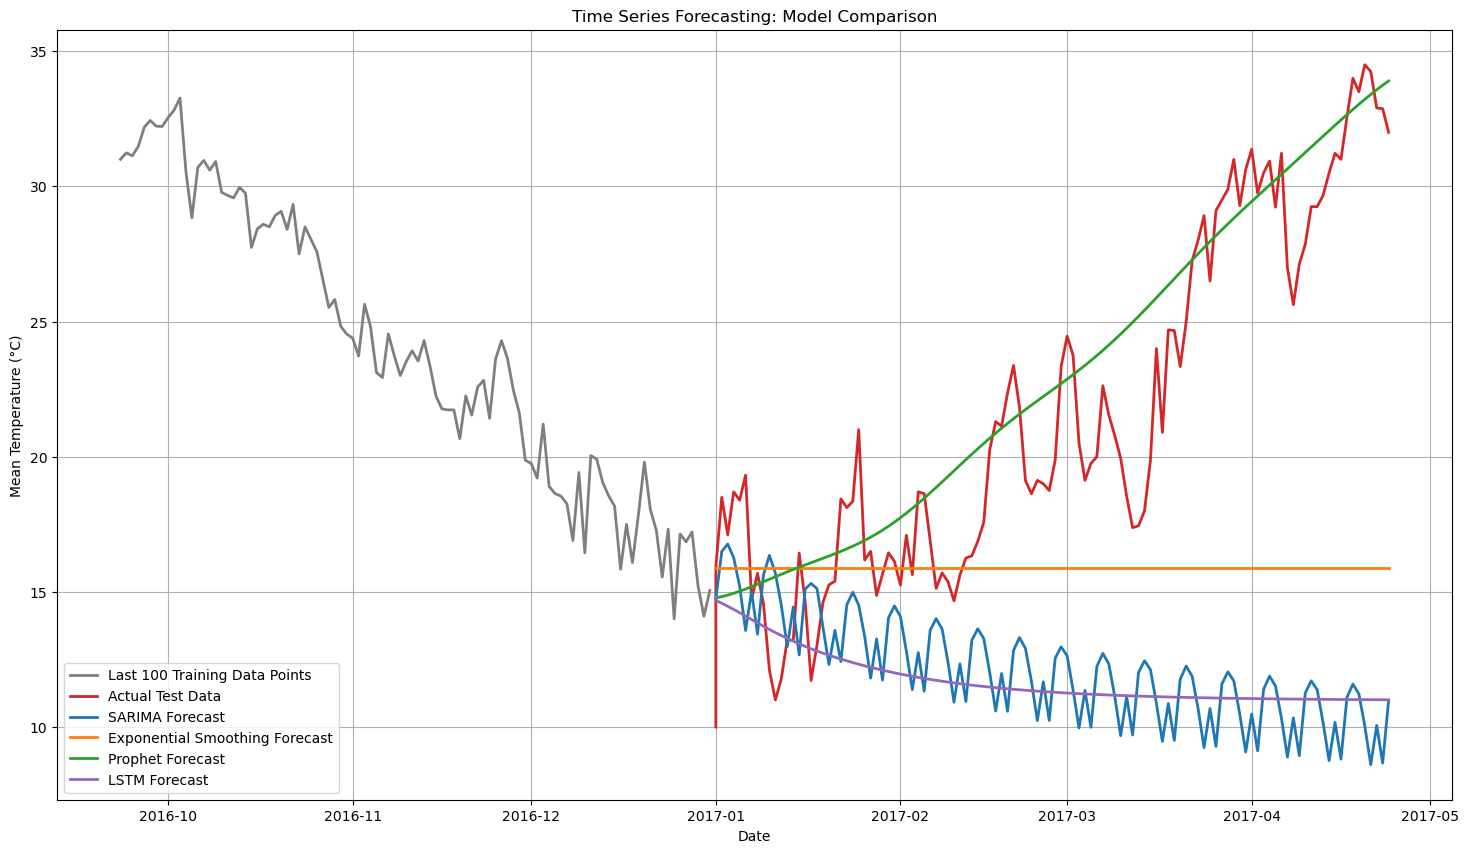

In [92]:
plt.figure(figsize=(18, 10))

# Plot the actual test data and last 100 training points
plt.plot(train_series.tail(100), color='#7f7f7f', label='Last 100 Training Data Points', linewidth=2)
plt.plot(test_series, color='#d62728', label='Actual Test Data', linewidth=2)

# Assign distinct colors for each model
model_colors = {
    'SARIMA': '#1f77b4',               # blue
    'Exponential Smoothing': '#ff7f0e',# orange
    'Prophet': '#2ca02c',              # green
    'LSTM': '#9467bd'                  # purple
}

for model_name, forecast_series in forecasts.items():
    plt.plot(forecast_series, label=f'{model_name} Forecast', color=model_colors.get(model_name, None), linewidth=2)

plt.title('Time Series Forecasting: Model Comparison')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

### 5. Conclusion and Reporting
This project successfully applied and compared four distinct time series forecasting techniques—SARIMA, Exponential Smoothing, Prophet, and LSTM—on the Daily Delhi Climate dataset. The objective was to evaluate their performance in predicting daily mean temperature and to identify the strengths and weaknesses of each approach.

**Key Findings and Model Performance**
The evaluation metrics (RMSE and MAE) and the visual analysis of the forecasts reveal significant differences in model performance. The key findings are:

* Prophet as the Best Performer: The Prophet model yielded the lowest RMSE (2.86) and MAE (2.32), indicating it was the most accurate model at predicting the mean temperature in the test set. This is not surprising, as Prophet is specifically designed to handle time series data with strong seasonal patterns and can be highly effective with minimal hyperparameter tuning.

* Exponential Smoothing as the Runner-up: The Exponential Smoothing model performed well with a low RMSE of 8.59. This model effectively captured the overall trend and seasonality, as evidenced by its relatively low error compared to SARIMA and LSTM.

* SARIMA and LSTM Underperformed: Both SARIMA (RMSE: 12.32) and LSTM (RMSE: 12.12) struggled to provide accurate forecasts, as indicated by their higher error metrics. However, a visual inspection of the SARIMA forecast showed it was the only model to visually track the annual seasonal cycle of the test data. This suggests that while its overall error was high, its core strength of capturing seasonality was present. The LSTM model's poor performance is likely due to a short sequence length (30 days), which prevented it from learning the long-term annual seasonality.